In [2]:
from load_data import pull_from_postgres
from psycopg2.sql import SQL
import pandas as pd

colors = ['#D06B62', '#5F9FCA']

def age(answer_id):
    return 85 - (answer_id - 807) * 5

# pull covid test results and test types from postgres
test_data = pull_from_postgres(SQL("""
    SELECT
        features.f10 test_result, features.f133 age, features.f127 sex, features.test_week_start, features.user_id, answers.element test_type
    FROM
        datenspende_derivatives.homogenized_features features, datenspende.answers answers
    WHERE
        features.test_week_start >= '2022-01-01' AND
        features.test_week_start < '2022-08-01' AND
        features.questionnaire_session = answers.questionnaire_session AND
        answers.question = 91
    """)).replace(
    {
        'test_type': {547: 'PCR', 548: 'Antigen', 549: 'Antibody', 550: 'Unknown', 1436: 'PCR'},
        'sex': {773: 'Female', 774: 'Male', 775: 'Divers', None: 'Unknown', float('nan'): 'Unknown'},
        'age': {float(answer_id): age(answer_id) for answer_id in list(range(807,822))}
    })

# convert date to pandas datetime
test_data['date'] = pd.to_datetime(test_data['test_week_start'])
test_data.drop(columns=['test_week_start'], inplace=True)
print(f"{len(test_data['user_id'].unique())} unique users")
print(f"{test_data['test_result'].sum()} positive test results")
# print number of negative test results
print(f"{test_data[test_data['test_result']==0]['test_result'].count() - test_data['test_result'].sum()} negative test results")
# count number of rows where test_result is nan
print(f"{test_data[test_data['test_result'].isna()].shape[0]} test results missing")
test_data

________________________________________________________________________________
[Memory] Calling load_data.pull_from_postgres...
pull_from_postgres(SQL("\n    SELECT\n        features.f10 test_result, features.f133 age, features.f127 sex, features.test_week_start, features.user_id, answers.element test_type\n    FROM\n        datenspende_derivatives.homogenized_features features, datenspende.answers answers\n    WHERE\n        features.test_week_start >= '2022-01-01' AND\n        features.test_week_start < '2022-08-01' AND\n        features.questionnaire_session = answers.questionnaire_session AND\n        answers.question = 91\n    "))


/home/kolb/.cache/pypoetry/virtualenvs/ml-nowcasting-e-o6ke1Z-py3.8/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


_______________________________________________pull_from_postgres - 5.8s, 0.1min
24331 unique users
12790 positive test results
171439 negative test results
519 test results missing


,test_result,age,sex,user_id,test_type,date
0,False,45.0,Male,361397,Antigen,2022-04-09
1,True,45.0,Female,581856,PCR,2022-04-09
2,False,40.0,Male,288844,PCR,2022-04-09
3,False,35.0,Male,482791,Antigen,2022-04-09
4,False,35.0,Male,1130800,Antigen,2022-04-09
...,...,...,...,...,...,...
197533,False,65.0,Female,290134,PCR,2022-05-09
197534,False,40.0,Male,873012,Antigen,2022-05-09
197535,False,40.0,Male,1156554,Antigen,2022-05-09
197536,False,60.0,Female,1115784,Antigen,2022-05-09


In [3]:
tests_per_user = test_data.groupby('user_id')['test_result'].count()
print(f'mean tests per user: {tests_per_user.mean()}')
print(f'median tests per user: {tests_per_user.median()}')
print(f'max tests per user: {tests_per_user.max()}')
print(f'std tests per user: {tests_per_user.std()}')

mean tests per user: 8.097447700464429
median tests per user: 5.0
max tests per user: 31
std tests per user: 7.499329882385607


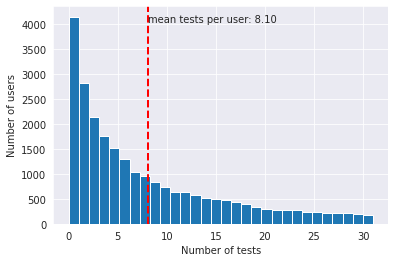

In [4]:
# plot histogram of test results per user
import matplotlib.pyplot as plt
tests_per_user.hist(bins=30)
ax = plt.gca()
ax.set_xlabel('Number of tests')
ax.set_ylabel('Number of users')

# plot vertical line with mean test results per user
plt.axvline(x=tests_per_user.mean(), color='r', linestyle='dashed', linewidth=2)
# label line with "mean tests per user"
plt.text(tests_per_user.mean(), 4000, f'mean tests per user: {tests_per_user.mean():.2f}', rotation=0, verticalalignment='bottom')
plt.savefig('tests_per_user.png')

In [54]:
# shares of sexesb
sex = test_data.groupby('user_id').first().groupby('sex').count()[['test_result']].rename(columns={'test_result': 'count'})
sex['share'] = sex['count'] / sex['count'].sum()
sex['share'] * 100

sex
Divers      0.191683
Female     35.890491
Male       54.171181
Unknown     9.746646
Name: share, dtype: float64

In [6]:
# average age
age = test_data.groupby('user_id').first()['age']
print(f'mean age: {age.mean()}')
print(f'std age: {age.std()}')

mean age: 48.05451943495522
std age: 14.21175537010652


In [7]:
# count first positive test in a row as infection
infections = test_data.sort_values(['user_id', 'date']).ffill()
infections['infection'] = infections.replace({True: 1, False: 0}).groupby(['user_id'])['test_result'].diff()
infections['infection'] = infections['infection'].fillna(0).replace({-1: 0})

In [8]:
# count reinfections (users with more than one sequence of positive tests)
df = infections.groupby(['user_id']).sum()['infection']
print(f'we have {df[df > 1].count()} reinfections in our data')

we have 118 reinfections in our data


In [9]:
infections['infection'].sum()

6497.0

In [10]:
# aggregate by user_id
df = infections.groupby(['test_type', 'date']).agg({'infection': ['sum', 'count']}).reset_index().sort_values(['date', 'test_type'])
df.columns = ['test_type', 'date', 'sum', 'count']

# count all reports (with or without test) for a given day
all_tests = df.groupby(['date']).agg({'sum': 'sum', 'count': 'sum'}).reset_index()
all_tests['test_type'] = 'all'
sum_of_daily_tests = pd.concat([df, all_tests]).reset_index(drop=True).sort_values(['date', 'test_type'])
sum_of_daily_tests

,test_type,date,sum,count
0,Antibody,2022-01-01,0.0,12
1,Antigen,2022-01-01,0.0,1037
2,PCR,2022-01-01,0.0,88
3,Unknown,2022-01-01,0.0,3
833,all,2022-01-01,0.0,1140
...,...,...,...,...
829,Antibody,2022-07-31,0.0,1
830,Antigen,2022-07-31,10.0,516
831,PCR,2022-07-31,6.0,30
832,Unknown,2022-07-31,1.0,2


In [11]:
# generate dataframe with sum of positive tests per type per day
positive_tests = sum_of_daily_tests[['test_type', 'sum', 'date']].rename(columns={'sum': 'positive_tests'}).set_index(['date', 'test_type']).unstack('test_type')
positive_tests.columns = positive_tests.columns.droplevel(0)

# generate dataframe with sum of all reports per day
all_daily_reports = sum_of_daily_tests[['test_type', 'count', 'date']].rename(columns={'count': 'all_daily_reports'}).set_index(['date', 'test_type']).unstack('test_type')
all_daily_reports.columns = all_daily_reports.columns.droplevel(0)
all_daily_reports = all_daily_reports[['all']].rename(columns={'all': 'all_daily_reports'})

daily_aggregate_test_data = positive_tests.merge(all_daily_reports, on='date', how='outer')
daily_aggregate_test_data

test_type,Antibody,Antigen,PCR,Unknown,all,all_daily_reports
date,,,,,,
2022-01-01,0.0,0.0,0.0,0.0,0.0,1140.0
2022-01-02,0.0,0.0,0.0,0.0,0.0,1307.0
2022-01-03,0.0,0.0,0.0,0.0,0.0,803.0
2022-01-04,0.0,0.0,0.0,0.0,0.0,1286.0
2022-01-05,0.0,0.0,0.0,0.0,0.0,1467.0
...,...,...,...,...,...,...
2022-07-27,0.0,6.0,13.0,0.0,19.0,597.0
2022-07-28,0.0,8.0,11.0,0.0,19.0,599.0
2022-07-29,0.0,15.0,9.0,0.0,24.0,537.0


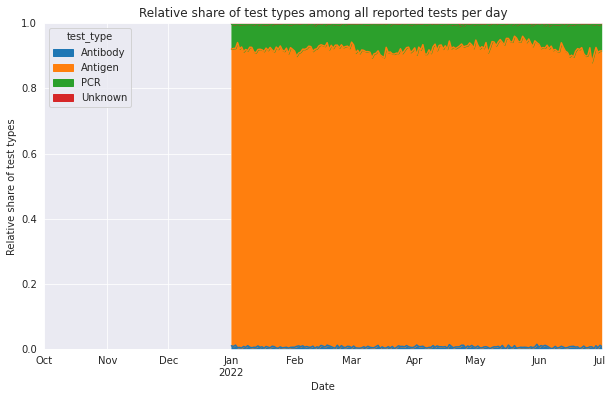

In [12]:
import matplotlib.pyplot as plt

all_daily_reports = sum_of_daily_tests[['test_type', 'count', 'date']].rename(columns={'count': 'all_daily_reports'}).set_index(['date', 'test_type']).unstack('test_type')
all_daily_reports.columns = all_daily_reports.columns.droplevel(0)

# normalize by all daily reports
for column in all_daily_reports.columns:
    all_daily_reports[column] = all_daily_reports[column] / all_daily_reports['all']

fig, ax = plt.subplots(figsize=(10, 6))

# plot relative share of test types among all reported tests per day
all_daily_reports[['Antibody', 'Antigen', 'PCR', 'Unknown']].plot.area(ax=ax)
ax.set_ylabel('Relative share of test types')
ax.set_xlabel('Date')
ax.set_title('Relative share of test types among all reported tests per day')
ax.set_xlim(pd.to_datetime('2021-10-01'), pd.to_datetime('2022-07-2'))
ax.set_ylim(0, 1)

all_daily_reports.to_csv('all_daily_reports.csv')

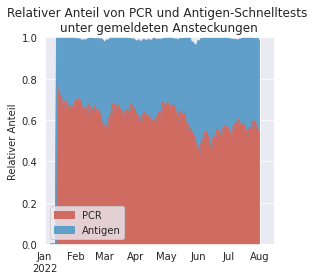

In [13]:
import matplotlib.pyplot as plt

df = daily_aggregate_test_data.copy()

# divide by all
for column in df.columns:
    df[column] = df[column] / df['all']

df.dropna(subset=['all'], inplace=True)

# take 7 day rolling mean
df = df.rolling(7).mean()

fig, ax = plt.subplots(figsize=(4, 4))

# plot relative share of antibody, antigen, PCR, unknown tests
df[['PCR', 'Antigen']].plot.area(ax=ax, color=colors)
ax.set_xlabel('')
ax.set_ylabel('Relativer Anteil')
ax.legend(loc='lower left')
ax.set_title('Relativer Anteil von PCR und Antigen-Schnelltests \nunter gemeldeten Ansteckungen')
ax.set_xlim(pd.to_datetime('2021-10-20'), pd.to_datetime('2022-07-2'))
ax.set_ylim(0, 1)
ax.set_xlim([pd.to_datetime('20220101'), pd.to_datetime('20220815')])
# ax.text(0.92, 0.95, 'A)', transform=ax.transAxes, fontsize=24, verticalalignment='top')

fig.tight_layout()

fig.savefig('relative_shares_of_test_type_among_positive_tests_per_day.png', dpi=200)

df.to_csv('relative_shares_of_test_type_among_positive_tests_per_day.csv')

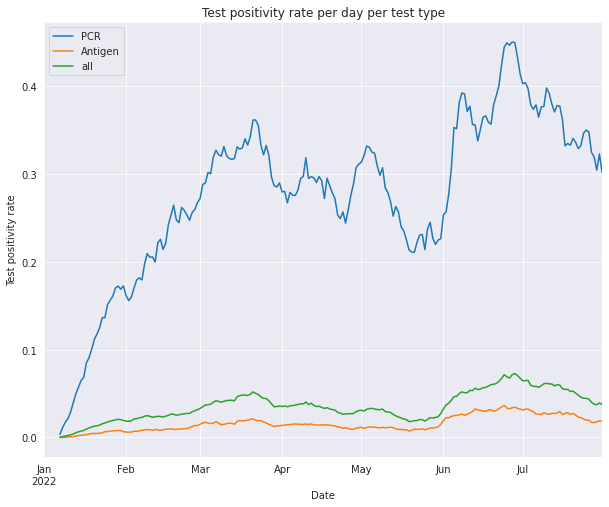

In [14]:
# plot test positivity rate for each test type per day
sum_of_daily_tests['rate'] = sum_of_daily_tests['sum'] / sum_of_daily_tests['count']

df = sum_of_daily_tests[['rate', 'date', 'test_type']].set_index(['date', 'test_type']).unstack('test_type')
df.columns = df.columns.droplevel(0)
df = df.rolling(7).mean()

fig, ax = plt.subplots(figsize=(10, 8))
df[['PCR', 'Antigen', 'all']].plot(ax=ax)

ax.set_xlabel('Date')
ax.set_ylabel('Test positivity rate')
ax.legend(loc='upper left')
ax.set_title('Test positivity rate per day per test type')
plt.show()

In [15]:
daily_aggregate_test_data

test_type,Antibody,Antigen,PCR,Unknown,all,all_daily_reports
date,,,,,,
2022-01-01,0.0,0.0,0.0,0.0,0.0,1140.0
2022-01-02,0.0,0.0,0.0,0.0,0.0,1307.0
2022-01-03,0.0,0.0,0.0,0.0,0.0,803.0
2022-01-04,0.0,0.0,0.0,0.0,0.0,1286.0
2022-01-05,0.0,0.0,0.0,0.0,0.0,1467.0
...,...,...,...,...,...,...
2022-07-27,0.0,6.0,13.0,0.0,19.0,597.0
2022-07-28,0.0,8.0,11.0,0.0,19.0,599.0
2022-07-29,0.0,15.0,9.0,0.0,24.0,537.0


Antibody <class 'str'>
Antigen <class 'str'>
PCR <class 'str'>
Unknown <class 'str'>
all <class 'str'>
all_daily_reports <class 'str'>


<AxesSubplot:xlabel='date'>

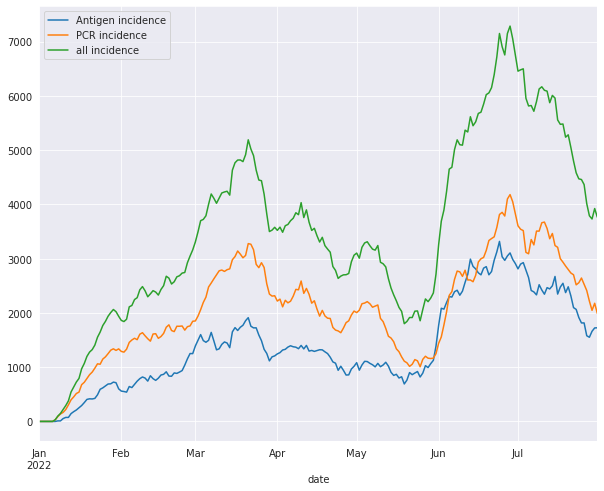

In [16]:
# calcualte 7 day incidence per test type

df = daily_aggregate_test_data.copy()
incidence = pd.DataFrame()
for column in df.columns:
    print(column, type(column))
    incidence[column + ' incidence'] = df[column] / df['all_daily_reports'] * 100_000

incidence = incidence[['Antigen incidence', 'PCR incidence', 'all incidence']].dropna().rolling('7D').mean()

fig, ax = plt.subplots(figsize=(10, 8))
incidence.plot(ax=ax)

In [17]:
incidence_official = pull_from_postgres(SQL(
    """
    SELECT date_of_report date, incidence_7d_per_100k official_incidence FROM coronacases.german_counties_incidence WHERE location_level = 0;
    """))
incidence_official

,date,official_incidence
0,2020-08-03,6.435577
1,2020-01-02,NaN
2,2020-01-03,NaN
3,2020-01-04,NaN
4,2020-01-05,NaN
...,...,...
959,2020-11-13,162.734634
960,2020-11-14,162.557175
961,2020-11-15,160.934738
962,2020-11-16,159.297211


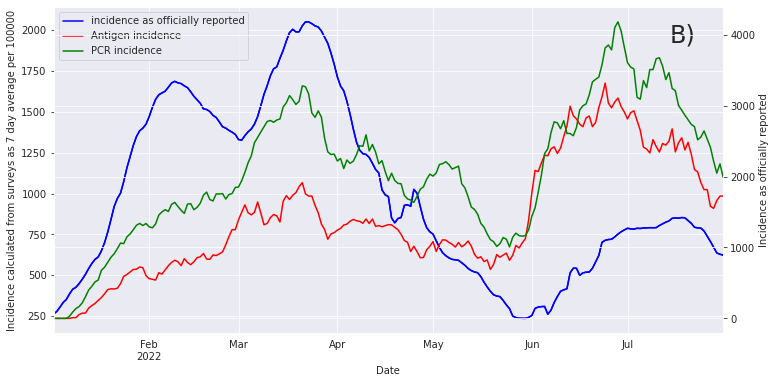

In [18]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

columns = incidence.columns.drop('all incidence')

df = incidence_official.merge(incidence, on='date').sort_values(by="date").reset_index(drop=True).query('date>20220101').drop(columns=['all incidence'])

fig, ax = plt.subplots(figsize=(12, 6))
axb = ax.twinx()

ax1 = df.plot(x="date", y="official_incidence", ax=ax, label="incidence as officially reported", color='blue', legend=False)
ax1 = df.plot(x="date", y="official_incidence", ax=ax, label="incidence as officially reported", color='blue', legend=False)

colors = ['red', 'green', 'black']
incidence_lines = []
for column, color in zip(columns, colors):
    incidence_lines.append(Line2D([0], [0], color=color, label=column))
    ax2 = df.plot(x="date", y=column, ax=axb, label="incidence from surveys", color=color, legend=False)

# create legend manually
labels = ['incidence as officially reported', *incidence.columns.values]
blue_line = Line2D([0], [0], color='blue', label='official incidence')
red_line = Line2D([0], [0], color='red', label='self reported incidence')
ax.legend([blue_line, *incidence_lines], labels, loc='upper left')

# label axes
ax.set_xlabel('Date')
ax.set_ylabel('Incidence calculated from surveys as 7 day average per 100000')
axb.set_ylabel('Incidence as officially reported')

# label plot as B)
ax.text(0.92, 0.95, 'B)', transform=ax.transAxes, fontsize=24, verticalalignment='top')

fig.savefig('incidence_pcr_vs_antigen_vs_reported.png')

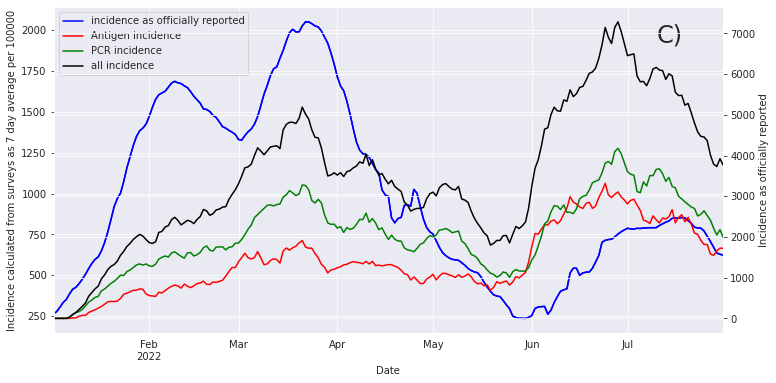

In [19]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

columns = incidence.columns

df = incidence_official.merge(incidence, on='date').sort_values(by="date").reset_index(drop=True).query('date>20220101')

fig, ax = plt.subplots(figsize=(12, 6))
axb = ax.twinx()

ax1 = df.plot(x="date", y="official_incidence", ax=ax, label="incidence as officially reported", color='blue', legend=False)
ax1 = df.plot(x="date", y="official_incidence", ax=ax, label="incidence as officially reported", color='blue', legend=False)

colors = ['red', 'green', 'black']
incidence_lines = []
for column, color in zip(columns, colors):
    incidence_lines.append(Line2D([0], [0], color=color, label=column))
    ax2 = df.plot(x="date", y=column, ax=axb, label="incidence from surveys", color=color, legend=False)

# create legend manually
labels = ['incidence as officially reported', *incidence.columns.values]
blue_line = Line2D([0], [0], color='blue', label='official incidence')
red_line = Line2D([0], [0], color='red', label='self reported incidence')
ax.legend([blue_line, *incidence_lines], labels, loc='upper left')

# label axes
ax.set_xlabel('Date')
ax.set_ylabel('Incidence calculated from surveys as 7 day average per 100000')
axb.set_ylabel('Incidence as officially reported')


ax.text(0.9, 0.95, 'C)', transform=ax.transAxes, fontsize=24, verticalalignment='top')

fig.savefig('incidence_all.png')

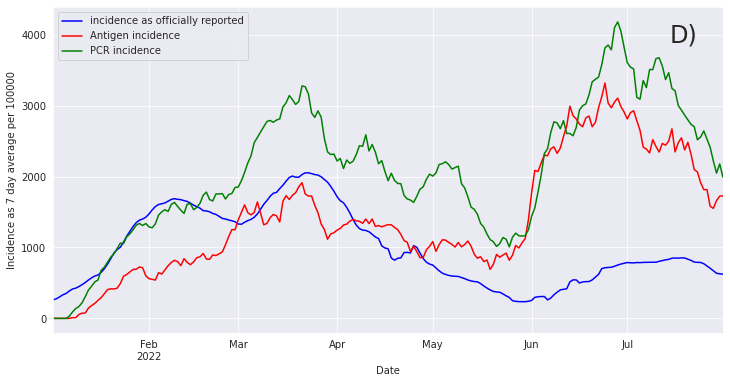

In [20]:
columns = incidence.columns.drop('all incidence')

df = incidence_official.merge(incidence, on='date').sort_values(by="date").reset_index(drop=True).query('date>20220101').drop(columns=['all incidence'])

fig, ax = plt.subplots(figsize=(12, 6))

ax1 = df.plot(x="date", y="official_incidence", ax=ax, label="incidence as officially reported", color='blue', legend=False)

colors = ['red', 'green', 'black']
incidence_lines = []
for column, color in zip(columns, colors):
    incidence_lines.append(Line2D([0], [0], color=color, label=column))
    ax2 = df.plot(x="date", y=column, ax=ax, label="incidence from surveys", color=color, legend=False)

# create legend manually
labels = ['incidence as officially reported', *incidence.columns.values]
blue_line = Line2D([0], [0], color='blue', label='official incidence')
red_line = Line2D([0], [0], color='red', label='self reported incidence')
ax.legend([blue_line, *incidence_lines], labels, loc='upper left')

# label axes
ax.set_xlabel('Date')
ax.set_ylabel('Incidence as 7 day average per 100000')
axb.set_ylabel('Incidence as officially reported')

ax.text(0.92, 0.95, 'D)', transform=ax.transAxes, fontsize=24, verticalalignment='top')

fig.savefig('incidence_pcr_vs_antigen_vs_reported_on_same_ax.png')

all incidence


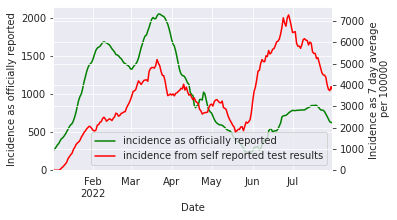

In [21]:
columns = incidence.columns.drop(['PCR incidence', 'Antigen incidence'])

df = incidence_official.merge(incidence, on='date').sort_values(by="date").reset_index(drop=True).query('date>20220101').drop(columns=['PCR incidence', 'Antigen incidence'])

fig, ax = plt.subplots(figsize=(5, 3))

axb = ax.twinx()

ax1 = df.plot(x="date", y="official_incidence", ax=ax, label="incidence as officially reported", color=colors[1], legend=False)


incidence_lines = []
for column, color in zip(columns, colors):
    print(column)
    incidence_lines.append(Line2D([0], [0], color=color, label=column))
    ax2 = df.plot(x="date", y=column, ax=axb, label="incidence from surveys", color=color, legend=False)

# create legend manually
labels = ['incidence as officially reported', 'incidence from self reported test results']
red_line = Line2D([0], [0], color=colors[0], label='self reported incidence')
blue_line = Line2D([0], [0], color=colors[1], label='official incidence')
ax.legend([blue_line, *incidence_lines], labels, loc='lower right')

# label axes
ax.set_xlabel('Date')
axb.set_ylabel('Incidence as 7 day average \nper 100000')
ax.set_ylabel('Incidence as officially reported')
ax.set_ylim(0, ax.get_ylim()[1])
axb.set_ylim(0, axb.get_ylim()[1])

# ax.text(0.92, 0.95, 'A)', transform=ax.transAxes, fontsize=24, verticalalignment='top')

fig.savefig('official_vs_reported_on_different_ax.png')

In [22]:
# divide official incidence by initial value
df = incidence_official.merge(incidence, on='date').sort_values(by="date").reset_index(drop=True).query('date>20211115').drop(columns=['PCR incidence', 'Antigen incidence'])
df['official_incidence'] = df['official_incidence'] / df['official_incidence'].iloc[0]
df['all incidence'] = df['all incidence'] / df['all incidence'].iloc[0]
df

,date,official_incidence,all incidence
0,2022-01-01,1.000000,NaN
1,2022-01-02,1.020310,NaN
2,2022-01-03,1.076408,NaN
3,2022-01-04,1.179932,NaN
4,2022-01-05,1.291581,NaN
...,...,...,...
207,2022-07-27,2.743988,inf
208,2022-07-28,2.605394,inf
209,2022-07-29,2.471186,inf
210,2022-07-30,2.439210,inf


all incidence


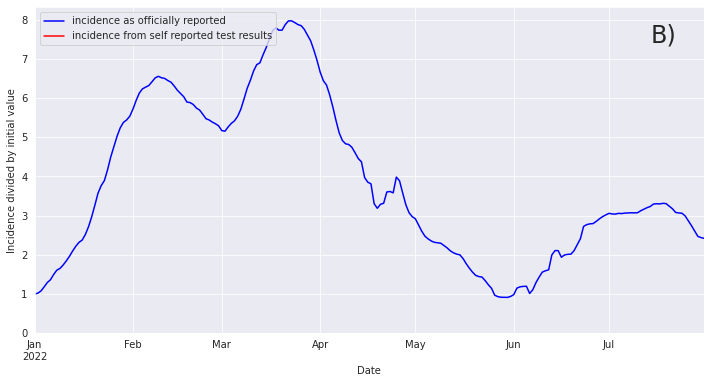

In [23]:
fig, ax = plt.subplots(figsize=(12, 6))

ax1 = df.plot(x="date", y="official_incidence", ax=ax, label="incidence as officially reported", color='blue', legend=False)

colors = ['red', 'green', 'black']
incidence_lines = []
for column, color in zip(columns, colors):
    print(column)
    incidence_lines.append(Line2D([0], [0], color=color, label=column))
    ax2 = df.plot(x="date", y=column, ax=ax, label="incidence from surveys", color=color, legend=False)

# create legend manually
labels = ['incidence as officially reported', 'incidence from self reported test results']
blue_line = Line2D([0], [0], color='blue', label='official incidence')
red_line = Line2D([0], [0], color='red', label='self reported incidence')
ax.legend([blue_line, *incidence_lines], labels, loc='upper left')

# label axes
ax.set_xlabel('Date')
ax.set_ylabel('Incidence divided by initial value')
ax.set_ylim(0, ax.get_ylim()[1])
axb.set_ylim(0, axb.get_ylim()[1])

ax.text(0.92, 0.95, 'B)', transform=ax.transAxes, fontsize=24, verticalalignment='top')
fig.savefig('incidence_divided_by_initial_value.png')

In [24]:
# plot all incidence divided by official incidence
df['self_reported_incidence_ratio'] =df['all incidence'] / df['official_incidence']

test_type = daily_aggregate_test_data[['Antigen', 'PCR']].groupby('date').sum().rolling(7).mean()
test_type['ratio'] = test_type['Antigen'] / test_type['PCR']
test_type.reset_index(inplace=True)

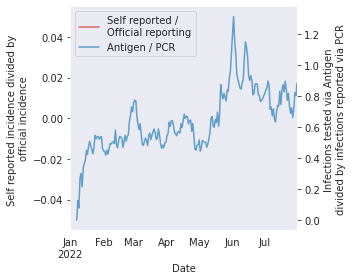

In [25]:
colors = ['#D06B62', '#5F9FCA']

fig, ax = plt.subplots(figsize=(5, 4))
axb = ax.twinx()
df.plot(x="date", y="self_reported_incidence_ratio", ax=ax, label="incidence as officially reported divided by self reported incidence", color=colors[0], legend=False)

test_type.plot(x='date', y='ratio', ax=axb, color=colors[1], legend=False)

ax.set_xlabel('Date')
ax.set_ylabel('Self reported incidence divided by \nofficial incidence')
axb.set_ylabel('Infections tested via Antigen \ndivided by infections reported via PCR')
# ax.text(0.92, 0.95, 'C)', transform=ax.transAxes, fontsize=24, verticalalignment='top')

handles = [Line2D([0], [0], color=colors[0]), Line2D([0], [0], color=colors[1])]
labels = ['Self reported / \nOfficial reporting', 'Antigen / PCR']
ax.legend(handles, labels, loc='upper left')
ax.grid(False)
axb.grid(False)
fig.tight_layout()
fig.savefig('incidence_ratio.png', dpi=300, transparent=True)

In [26]:
df = incidence_official.merge(incidence, on='date').sort_values(by="date").reset_index(drop=True).query('date>20220101').drop(columns=['PCR incidence', 'Antigen incidence'])
df['official R_t'] = df['official_incidence'].shift(-4) / df['official_incidence']
df['self reported R_t'] = df['all incidence'].shift(-4) / df['all incidence']
# set type of date to pandas datetime
df['date'] = pd.to_datetime(df['date'])
df = df.rolling(7, on='date', win_type='triang', center=True).mean()
df

,date,all incidence,official R_t,official_incidence,self reported R_t
1,2022-01-02,NaN,NaN,NaN,NaN
2,2022-01-03,NaN,NaN,NaN,NaN
3,2022-01-04,NaN,NaN,NaN,NaN
4,2022-01-05,9.949712,1.302308,331.008923,NaN
5,2022-01-06,27.260316,1.279130,355.995871,NaN
...,...,...,...,...,...
207,2022-07-27,4080.694838,NaN,705.279015,NaN
208,2022-07-28,3949.454939,NaN,677.387375,NaN
209,2022-07-29,NaN,NaN,NaN,NaN
210,2022-07-30,NaN,NaN,NaN,NaN


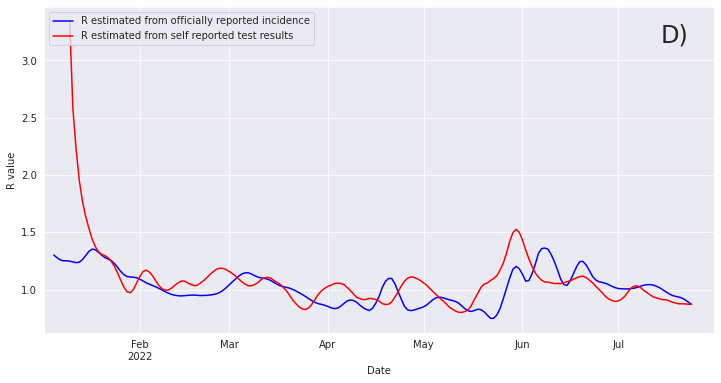

In [27]:
fig, ax = plt.subplots(figsize=(12, 6))

ax1 = df.plot(x="date", y="official R_t", ax=ax, label="R estimated from officially reported incidence", color='blue', legend=False)
ax2 = df.plot(x='date', y='self reported R_t', ax=ax, label="R estimated from self reported incidence", color='red', legend=False)

# create legend manually
labels = ['R estimated from officially reported incidence', 'R estimated from self reported test results']
blue_line = Line2D([0], [0], color='blue', label='official incidence')
red_line = Line2D([0], [0], color='red', label='self reported incidence')
ax.legend([blue_line, *incidence_lines], labels, loc='upper left')

# label axes
ax.set_xlabel('Date')
ax.set_ylabel('R value')

ax.text(0.92, 0.95, 'D)', transform=ax.transAxes, fontsize=24, verticalalignment='top')

fig.savefig('R_estimated_from_official_vs_reported.png')

/tmp/ipykernel_22615/3319997799.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['split'][df['date'] > pd.to_datetime('20220501')] = 'after May 2022'


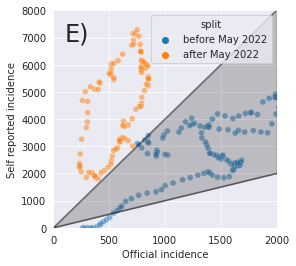

In [28]:
df = incidence_official.merge(incidence, on='date').sort_values(by="date").reset_index(drop=True).query('date>20220101').drop(columns=['PCR incidence', 'Antigen incidence'])
df['split'] = 'before May 2022'
df['split'][df['date'] > pd.to_datetime('20220501')] = 'after May 2022'

import seaborn as sns
# scatterplot of official vs self reported incidence with split by date
fig, ax = plt.subplots(figsize=(4, 4))
sns.scatterplot(x='official_incidence', y='all incidence', hue='split', data=df, ax=ax, alpha=0.5)

# plot line from (0, 0) to (5000, 5000)
factor = 4
length = 2000
ax.plot([0, length], [0, length * factor], color='black', alpha=0.5)
ax.plot([0, length], [0, length], color='black', alpha=0.5)
ax.fill_between([0, length], [0, length * factor], [0, length], color='black', alpha=0.2)
ax.set_xlim(0, length)
ax.set_ylim(0, length * factor)

ax.set_ylabel('Self reported incidence')
ax.set_xlabel('Official incidence')

# annotate with E in upper left corner
ax.text(0.05, 0.95, 'E)', transform=ax.transAxes, fontsize=24, verticalalignment='top')
fig.savefig('official_vs_self_reported_incidence_with_split.png')

/tmp/ipykernel_22615/1179108664.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['split'][df['date'] > split_date_1['date']] = f'after {split_date_1["name"]}'
/tmp/ipykernel_22615/1179108664.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['split'][df['date'] > split_date_2['date']] = f'after {split_date_2["name"]}'


all incidence


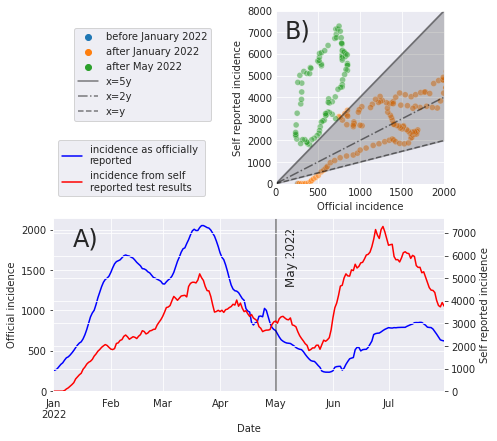

In [29]:
from typing import TypedDict
from datetime import timedelta

Date = TypedDict('Date', {'date': pd.Timestamp, 'name': str})

def plot_official_vs_self_reported_incidence(ax, legend_location, split_date: Date, df):
    axb = ax.twinx()

    df.plot(x="date", y="official_incidence", ax=ax, label="incidence as officially reported", color='blue', legend=False)

    colors = ['red']
    incidence_lines = []
    for column, color in zip(columns, colors):
        print(column)
        incidence_lines.append(Line2D([0], [0], color=color, label=column))
        df.plot(x="date", y=column, ax=axb, label="incidence from surveys", color=color, legend=False)

    # plot vertical line at split_date date and label with split date name
    ax.axvline(split_date['date'], color='black', alpha=0.5)
    ax.text(split_date['date'] + timedelta(days=5), ax.get_ylim()[1]*0.95 , split_date['name'], fontsize=12, verticalalignment='top', rotation=90)

    # create legend manually
    labels = ['incidence as officially \nreported', 'incidence from self \nreported test results']
    blue_line = Line2D([0], [0], color='blue', label='official incidence')
    ax.legend([blue_line, *incidence_lines], labels, bbox_to_anchor=legend_location)

    # label plot with A) in upper left corner
    axb.text(0.05, 0.95, 'A)', transform=ax.transAxes, fontsize=24, verticalalignment='top')

    # label axes
    ax.set_xlabel('Date')
    axb.set_ylabel('Self reported incidence')
    ax.set_ylabel('Official incidence')
    ax.set_ylim(0, ax.get_ylim()[1])
    axb.set_ylim(0, axb.get_ylim()[1])


def scatter_plot_with_split(ax, legend_location, split_date_1: Date, split_date_2: Date, df):

    df['split'] = f'before {split_date_1["name"]}'
    df['split'][df['date'] > split_date_1['date']] = f'after {split_date_1["name"]}'
    df['split'][df['date'] > split_date_2['date']] = f'after {split_date_2["name"]}'

    import seaborn as sns
    # scatterplot of official vs self reported incidence with split by date
    sns.scatterplot(x='official_incidence', y='all incidence', hue='split', data=df, ax=ax, alpha=0.5)

    # plot line from (0, 0) to (5000, 5000)
    factor = 4
    length = 2000

    ax.plot([0, length], [0, length * factor], label='x=5y', color='black', alpha=0.5)
    ax.plot([0, length], [0, length * 2], '-.', label='x=2y', color='black', alpha=0.5)
    ax.plot([0, length], [0, length], '--', label='x=y', color='black', alpha=0.5)

    ax.fill_between([0, length], [0, length * factor], [0, length], color='black', alpha=0.2)
    ax.set_xlim(0, length)
    ax.set_ylim(0, length * factor)

    # set legend position outside of plot on lower right
    ax.legend(loc='upper left', bbox_to_anchor=legend_location)

    # remove axis tics
    ax.tick_params(axis='both', which='both', length=0)
    # remove axis labels
    # ax.set_xticklabels([])
    # ax.set_yticklabels([])

    ax.set_ylabel('Self reported incidence')
    ax.set_xlabel('Official incidence')

    # label plot with B) in upper left corner
    ax.text(0.05, 0.95, 'B)', transform=ax.transAxes, fontsize=24, verticalalignment='top')

gridspecs = dict(width_ratios=[1, .9], height_ratios=[1, 1])
fig, axs = plt.subplot_mosaic([['upper left', 'upper right'],
                               ['lower', 'lower']], gridspec_kw=gridspecs, figsize=(7, 7))
# delete upper left subplot
axs['upper left'].remove()

df = incidence_official.merge(incidence, on='date').sort_values(by="date").reset_index(drop=True).query('date>20211115').drop(columns=['PCR incidence', 'Antigen incidence'])

scatter_plot_with_split(
    ax=axs['upper right'],
    legend_location=(-1.23, 0.93),
    split_date_1=dict(date=pd.to_datetime('20220101'), name='January 2022'),
    split_date_2=dict(date=pd.to_datetime('20220501'), name='May 2022'),
    df=df
)

plot_official_vs_self_reported_incidence(
    ax=axs['lower'],
    legend_location=(.4, 1.48),
    split_date=dict(date=pd.to_datetime('20220501'), name='May 2022'),
    df=df)
fig.savefig('official_vs_self_reported_incidence_with_scatter_subplot.png')

In [30]:
# generate dataframe with sum of positive tests per type per day
positive_tests = sum_of_daily_tests[['test_type', 'sum', 'date']].rename(columns={'sum': 'positive_tests'}).set_index(['date', 'test_type']).unstack('test_type')
positive_tests.columns = positive_tests.columns.droplevel(0)

# generate dataframe with sum of all reports per day
all_daily_reports = sum_of_daily_tests[['test_type', 'count', 'date']].rename(columns={'count': 'all_daily_reports'}).set_index(['date', 'test_type']).unstack('test_type')
all_daily_reports.columns = all_daily_reports.columns.droplevel(0)
all_daily_reports = all_daily_reports[['all']].rename(columns={'all': 'all_daily_reports'})

daily_aggregate_test_data = positive_tests.merge(all_daily_reports, on='date', how='outer')
daily_aggregate_test_data

test_type,Antibody,Antigen,PCR,Unknown,all,all_daily_reports
date,,,,,,
2022-01-01,0.0,0.0,0.0,0.0,0.0,1140.0
2022-01-02,0.0,0.0,0.0,0.0,0.0,1307.0
2022-01-03,0.0,0.0,0.0,0.0,0.0,803.0
2022-01-04,0.0,0.0,0.0,0.0,0.0,1286.0
2022-01-05,0.0,0.0,0.0,0.0,0.0,1467.0
...,...,...,...,...,...,...
2022-07-27,0.0,6.0,13.0,0.0,19.0,597.0
2022-07-28,0.0,8.0,11.0,0.0,19.0,599.0
2022-07-29,0.0,15.0,9.0,0.0,24.0,537.0


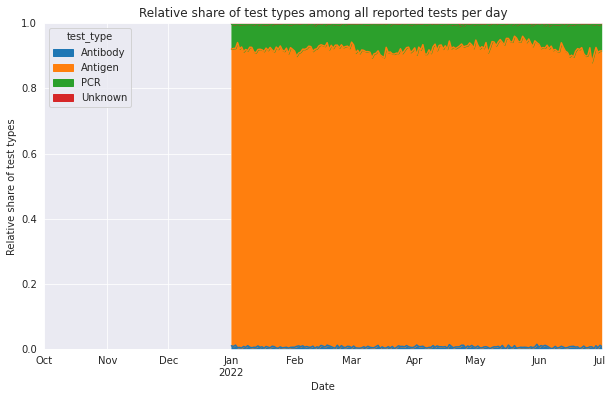

In [31]:
import matplotlib.pyplot as plt

all_daily_reports = sum_of_daily_tests[['test_type', 'count', 'date']].rename(columns={'count': 'all_daily_reports'}).set_index(['date', 'test_type']).unstack('test_type')
all_daily_reports.columns = all_daily_reports.columns.droplevel(0)

# normalize by all daily reports
for column in all_daily_reports.columns:
    all_daily_reports[column] = all_daily_reports[column] / all_daily_reports['all']

fig, ax = plt.subplots(figsize=(10, 6))

# plot relative share of test types among all reported tests per day
all_daily_reports[['Antibody', 'Antigen', 'PCR', 'Unknown']].plot.area(ax=ax)
ax.set_ylabel('Relative share of test types')
ax.set_xlabel('Date')
ax.set_title('Relative share of test types among all reported tests per day')
ax.set_xlim(pd.to_datetime('2021-10-01'), pd.to_datetime('2022-07-2'))
ax.set_ylim(0, 1)

all_daily_reports.to_csv('all_daily_reports.csv')

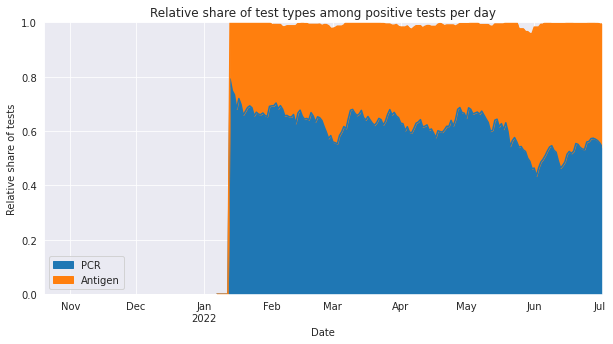

In [32]:
import matplotlib.pyplot as plt

df = daily_aggregate_test_data.copy()

# divide by all
for column in df.columns:
    df[column] = df[column] / df['all']

df.dropna(subset=['all'], inplace=True)

# take 7 day rolling mean
df = df.rolling(7).mean()

fig, ax = plt.subplots(figsize=(10, 5))

# plot relative share of antibody, antigen, PCR, unknown tests
df[['PCR', 'Antigen']].plot.area(ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Relative share of tests')
ax.legend(loc='lower left')
ax.set_title('Relative share of test types among positive tests per day')
ax.set_xlim(pd.to_datetime('2021-10-20'), pd.to_datetime('2022-07-2'))
ax.set_ylim(0, 1)
# ax.text(0.92, 0.95, 'A)', transform=ax.transAxes, fontsize=24, verticalalignment='top')
fig.savefig('relative_shares_of_test_type_among_positive_tests_per_day.png')

df.to_csv('relative_shares_of_test_type_among_positive_tests_per_day.csv')

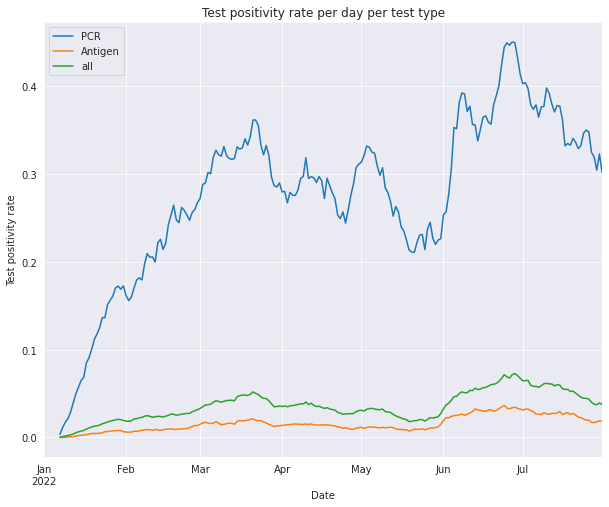

In [33]:
# plot test positivity rate for each test type per day
sum_of_daily_tests['rate'] = sum_of_daily_tests['sum'] / sum_of_daily_tests['count']

df = sum_of_daily_tests[['rate', 'date', 'test_type']].set_index(['date', 'test_type']).unstack('test_type')
df.columns = df.columns.droplevel(0)
df = df.rolling(7).mean()

fig, ax = plt.subplots(figsize=(10, 8))
df[['PCR', 'Antigen', 'all']].plot(ax=ax)

ax.set_xlabel('Date')
ax.set_ylabel('Test positivity rate')
ax.legend(loc='upper left')
ax.set_title('Test positivity rate per day per test type')
plt.show()

In [34]:
daily_aggregate_test_data

test_type,Antibody,Antigen,PCR,Unknown,all,all_daily_reports
date,,,,,,
2022-01-01,0.0,0.0,0.0,0.0,0.0,1140.0
2022-01-02,0.0,0.0,0.0,0.0,0.0,1307.0
2022-01-03,0.0,0.0,0.0,0.0,0.0,803.0
2022-01-04,0.0,0.0,0.0,0.0,0.0,1286.0
2022-01-05,0.0,0.0,0.0,0.0,0.0,1467.0
...,...,...,...,...,...,...
2022-07-27,0.0,6.0,13.0,0.0,19.0,597.0
2022-07-28,0.0,8.0,11.0,0.0,19.0,599.0
2022-07-29,0.0,15.0,9.0,0.0,24.0,537.0


Antibody <class 'str'>
Antigen <class 'str'>
PCR <class 'str'>
Unknown <class 'str'>
all <class 'str'>
all_daily_reports <class 'str'>


<AxesSubplot:xlabel='date'>

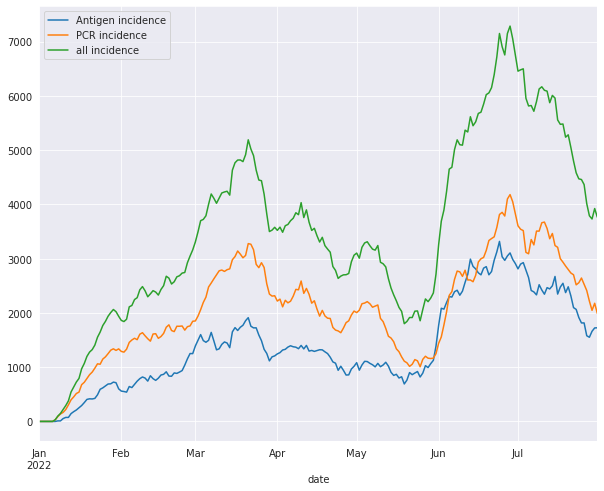

In [35]:
# calcualte 7 day incidence per test type

df = daily_aggregate_test_data.copy()
incidence = pd.DataFrame()
for column in df.columns:
    print(column, type(column))
    incidence[column + ' incidence'] = df[column] / df['all_daily_reports'] * 100_000

incidence = incidence[['Antigen incidence', 'PCR incidence', 'all incidence']].dropna().rolling('7D').mean()

fig, ax = plt.subplots(figsize=(10, 8))
incidence.plot(ax=ax)

In [36]:
incidence_official = pull_from_postgres(SQL(
    """
    SELECT date_of_report date, incidence_7d_per_100k official_incidence FROM coronacases.german_counties_incidence WHERE location_level = 0;
    """))
incidence_official

,date,official_incidence
0,2020-08-03,6.435577
1,2020-01-02,NaN
2,2020-01-03,NaN
3,2020-01-04,NaN
4,2020-01-05,NaN
...,...,...
959,2020-11-13,162.734634
960,2020-11-14,162.557175
961,2020-11-15,160.934738
962,2020-11-16,159.297211


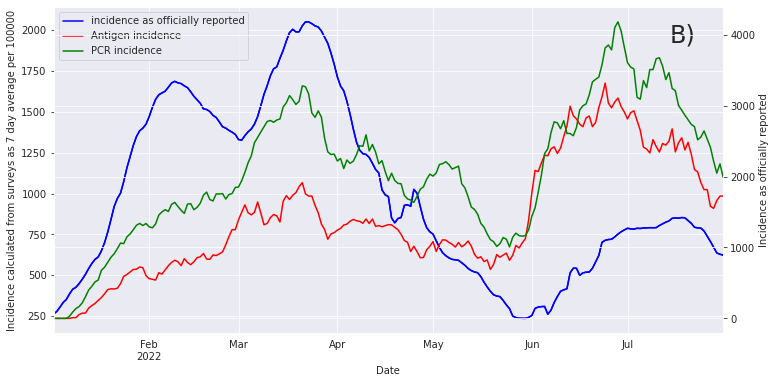

In [37]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

columns = incidence.columns.drop('all incidence')

df = incidence_official.merge(incidence, on='date').sort_values(by="date").reset_index(drop=True).query('date>20220101').drop(columns=['all incidence'])

fig, ax = plt.subplots(figsize=(12, 6))
axb = ax.twinx()

ax1 = df.plot(x="date", y="official_incidence", ax=ax, label="incidence as officially reported", color='blue', legend=False)
ax1 = df.plot(x="date", y="official_incidence", ax=ax, label="incidence as officially reported", color='blue', legend=False)

colors = ['red', 'green', 'black']
incidence_lines = []
for column, color in zip(columns, colors):
    incidence_lines.append(Line2D([0], [0], color=color, label=column))
    ax2 = df.plot(x="date", y=column, ax=axb, label="incidence from surveys", color=color, legend=False)

# create legend manually
labels = ['incidence as officially reported', *incidence.columns.values]
blue_line = Line2D([0], [0], color='blue', label='official incidence')
red_line = Line2D([0], [0], color='red', label='self reported incidence')
ax.legend([blue_line, *incidence_lines], labels, loc='upper left')

# label axes
ax.set_xlabel('Date')
ax.set_ylabel('Incidence calculated from surveys as 7 day average per 100000')
axb.set_ylabel('Incidence as officially reported')

# label plot as B)
ax.text(0.92, 0.95, 'B)', transform=ax.transAxes, fontsize=24, verticalalignment='top')

fig.savefig('incidence_pcr_vs_antigen_vs_reported.png')

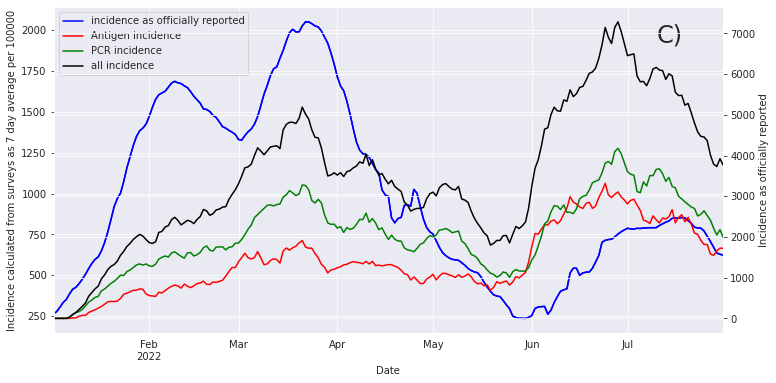

In [38]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

columns = incidence.columns

df = incidence_official.merge(incidence, on='date').sort_values(by="date").reset_index(drop=True).query('date>20220101')

fig, ax = plt.subplots(figsize=(12, 6))
axb = ax.twinx()

ax1 = df.plot(x="date", y="official_incidence", ax=ax, label="incidence as officially reported", color='blue', legend=False)
ax1 = df.plot(x="date", y="official_incidence", ax=ax, label="incidence as officially reported", color='blue', legend=False)

colors = ['red', 'green', 'black']
incidence_lines = []
for column, color in zip(columns, colors):
    incidence_lines.append(Line2D([0], [0], color=color, label=column))
    ax2 = df.plot(x="date", y=column, ax=axb, label="incidence from surveys", color=color, legend=False)

# create legend manually
labels = ['incidence as officially reported', *incidence.columns.values]
blue_line = Line2D([0], [0], color='blue', label='official incidence')
red_line = Line2D([0], [0], color='red', label='self reported incidence')
ax.legend([blue_line, *incidence_lines], labels, loc='upper left')

# label axes
ax.set_xlabel('Date')
ax.set_ylabel('Incidence calculated from surveys as 7 day average per 100000')
axb.set_ylabel('Incidence as officially reported')


ax.text(0.9, 0.95, 'C)', transform=ax.transAxes, fontsize=24, verticalalignment='top')

fig.savefig('incidence_all.png')

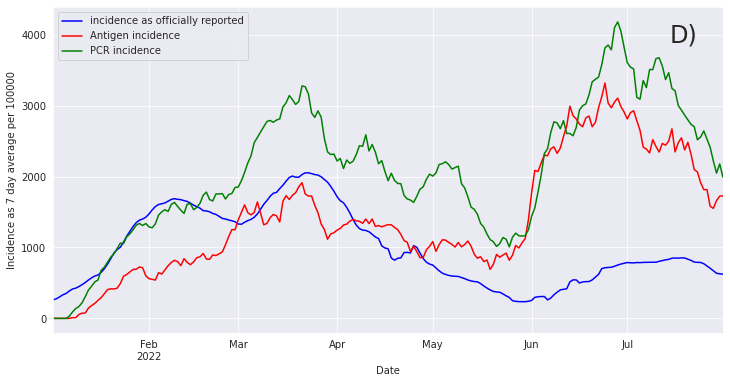

In [39]:
columns = incidence.columns.drop('all incidence')

df = incidence_official.merge(incidence, on='date').sort_values(by="date").reset_index(drop=True).query('date>20220101').drop(columns=['all incidence'])

fig, ax = plt.subplots(figsize=(12, 6))

ax1 = df.plot(x="date", y="official_incidence", ax=ax, label="incidence as officially reported", color='blue', legend=False)

colors = ['red', 'green', 'black']
incidence_lines = []
for column, color in zip(columns, colors):
    incidence_lines.append(Line2D([0], [0], color=color, label=column))
    ax2 = df.plot(x="date", y=column, ax=ax, label="incidence from surveys", color=color, legend=False)

# create legend manually
labels = ['incidence as officially reported', *incidence.columns.values]
blue_line = Line2D([0], [0], color='blue', label='official incidence')
red_line = Line2D([0], [0], color='red', label='self reported incidence')
ax.legend([blue_line, *incidence_lines], labels, loc='upper left')

# label axes
ax.set_xlabel('Date')
ax.set_ylabel('Incidence as 7 day average per 100000')
axb.set_ylabel('Incidence as officially reported')

ax.text(0.92, 0.95, 'D)', transform=ax.transAxes, fontsize=24, verticalalignment='top')

fig.savefig('incidence_pcr_vs_antigen_vs_reported_on_same_ax.png')

all incidence


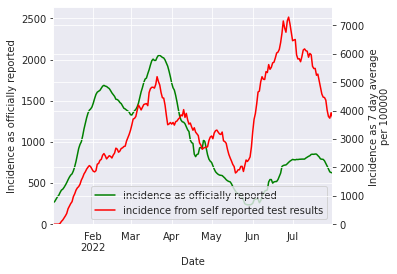

In [40]:
columns = incidence.columns.drop(['PCR incidence', 'Antigen incidence'])

df = incidence_official.merge(incidence, on='date').sort_values(by="date").reset_index(drop=True).query('date>20220101').drop(columns=['PCR incidence', 'Antigen incidence'])

fig, ax = plt.subplots(figsize=(5, 4))

axb = ax.twinx()

ax1 = df.plot(x="date", y="official_incidence", ax=ax, label="incidence as officially reported", color=colors[1], legend=False)

incidence_lines = []
for column, color in zip(columns, colors):
    print(column)
    incidence_lines.append(Line2D([0], [0], color=color, label=column))
    ax2 = df.plot(x="date", y=column, ax=axb, label="incidence from surveys", color=color, legend=False)

# create legend manually
labels = ['incidence as officially reported', 'incidence from self reported test results']
blue_line = Line2D([0], [0], color=colors[1], label='official incidence')
red_line = Line2D([0], [0], color=colors[0], label='self reported incidence')
ax.legend([blue_line, *incidence_lines], labels, loc='lower right')

# label axes
ax.set_xlabel('Date')
axb.set_ylabel('Incidence as 7 day average \nper 100000')
ax.set_ylabel('Incidence as officially reported')
ax.set_ylim(0, ax.get_ylim()[1]+500)
axb.set_ylim(0, axb.get_ylim()[1])

# ax.text(0.92, 0.95, 'A)', transform=ax.transAxes, fontsize=24, verticalalignment='top')

fig.savefig('official_vs_reported_on_different_ax.png')

In [41]:
# divide official incidence by initial value
df = incidence_official.merge(incidence, on='date').sort_values(by="date").reset_index(drop=True).query('date>20211115').drop(columns=['PCR incidence', 'Antigen incidence'])
df['official_incidence'] = df['official_incidence'] / df['official_incidence'].iloc[0]
df['all incidence'] = df['all incidence'] / df['all incidence'].iloc[0]
df

,date,official_incidence,all incidence
0,2022-01-01,1.000000,NaN
1,2022-01-02,1.020310,NaN
2,2022-01-03,1.076408,NaN
3,2022-01-04,1.179932,NaN
4,2022-01-05,1.291581,NaN
...,...,...,...
207,2022-07-27,2.743988,inf
208,2022-07-28,2.605394,inf
209,2022-07-29,2.471186,inf
210,2022-07-30,2.439210,inf


all incidence


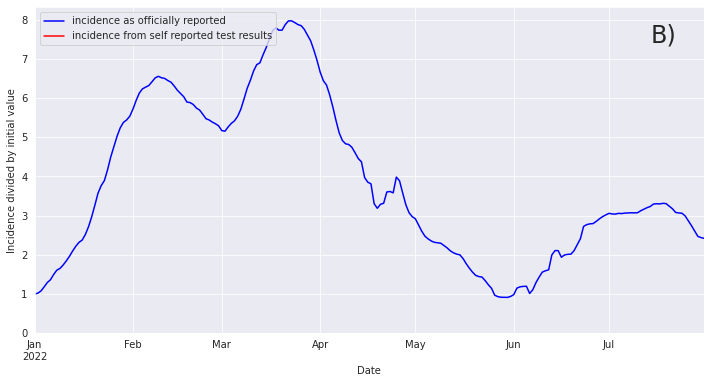

In [42]:
fig, ax = plt.subplots(figsize=(12, 6))

ax1 = df.plot(x="date", y="official_incidence", ax=ax, label="incidence as officially reported", color='blue', legend=False)

colors = ['red', 'green', 'black']
incidence_lines = []
for column, color in zip(columns, colors):
    print(column)
    incidence_lines.append(Line2D([0], [0], color=color, label=column))
    ax2 = df.plot(x="date", y=column, ax=ax, label="incidence from surveys", color=color, legend=False)

# create legend manually
labels = ['incidence as officially reported', 'incidence from self reported test results']
blue_line = Line2D([0], [0], color='blue', label='official incidence')
red_line = Line2D([0], [0], color='red', label='self reported incidence')
ax.legend([blue_line, *incidence_lines], labels, loc='upper left')

# label axes
ax.set_xlabel('Date')
ax.set_ylabel('Incidence divided by initial value')
ax.set_ylim(0, ax.get_ylim()[1])
axb.set_ylim(0, axb.get_ylim()[1])

ax.text(0.92, 0.95, 'B)', transform=ax.transAxes, fontsize=24, verticalalignment='top')
fig.savefig('incidence_divided_by_initial_value.png')

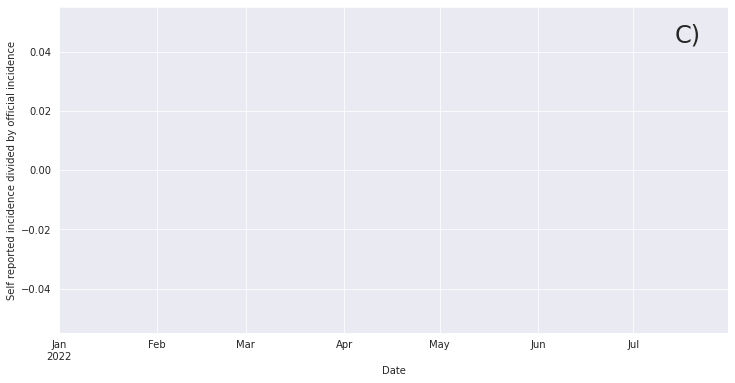

In [43]:
# plot all incidence divided by official incidence
df['self_reported_incidence_ratio'] =df['all incidence'] / df['official_incidence']

fig, ax = plt.subplots(figsize=(12, 6))
df.plot(x="date", y="self_reported_incidence_ratio", ax=ax, label="incidence as officially reported divided by self reported incidence", color='blue', legend=False)

ax.set_xlabel('Date')
ax.set_ylabel('Self reported incidence divided by official incidence')
ax.text(0.92, 0.95, 'C)', transform=ax.transAxes, fontsize=24, verticalalignment='top')
fig.savefig('incidence_ratio.png')

In [44]:
df = incidence_official.merge(incidence, on='date').sort_values(by="date").reset_index(drop=True).query('date>20220101').drop(columns=['PCR incidence', 'Antigen incidence'])
df['official R_t'] = df['official_incidence'].shift(-4) / df['official_incidence']
df['self reported R_t'] = df['all incidence'].shift(-4) / df['all incidence']
# set type of date to pandas datetime
df['date'] = pd.to_datetime(df['date'])
df = df.rolling(7, on='date', win_type='triang', center=True).mean()
df

,date,all incidence,official R_t,official_incidence,self reported R_t
1,2022-01-02,NaN,NaN,NaN,NaN
2,2022-01-03,NaN,NaN,NaN,NaN
3,2022-01-04,NaN,NaN,NaN,NaN
4,2022-01-05,9.949712,1.302308,331.008923,NaN
5,2022-01-06,27.260316,1.279130,355.995871,NaN
...,...,...,...,...,...
207,2022-07-27,4080.694838,NaN,705.279015,NaN
208,2022-07-28,3949.454939,NaN,677.387375,NaN
209,2022-07-29,NaN,NaN,NaN,NaN
210,2022-07-30,NaN,NaN,NaN,NaN


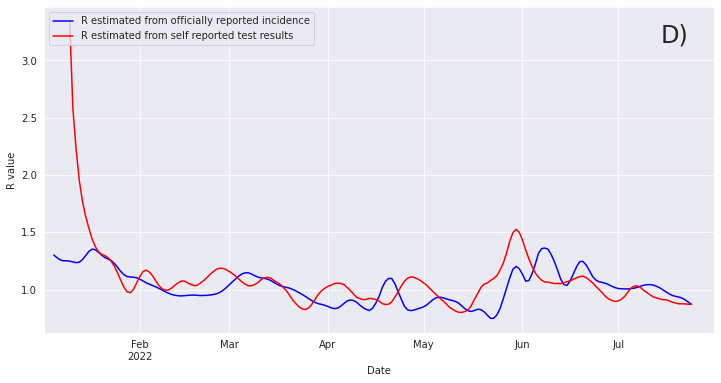

In [45]:
fig, ax = plt.subplots(figsize=(12, 6))

ax1 = df.plot(x="date", y="official R_t", ax=ax, label="R estimated from officially reported incidence", color='blue', legend=False)
ax2 = df.plot(x='date', y='self reported R_t', ax=ax, label="R estimated from self reported incidence", color='red', legend=False)

# create legend manually
labels = ['R estimated from officially reported incidence', 'R estimated from self reported test results']
blue_line = Line2D([0], [0], color='blue', label='official incidence')
red_line = Line2D([0], [0], color='red', label='self reported incidence')
ax.legend([blue_line, *incidence_lines], labels, loc='upper left')

# label axes
ax.set_xlabel('Date')
ax.set_ylabel('R value')

ax.text(0.92, 0.95, 'D)', transform=ax.transAxes, fontsize=24, verticalalignment='top')

fig.savefig('R_estimated_from_official_vs_reported.png')

/tmp/ipykernel_22615/3319997799.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['split'][df['date'] > pd.to_datetime('20220501')] = 'after May 2022'


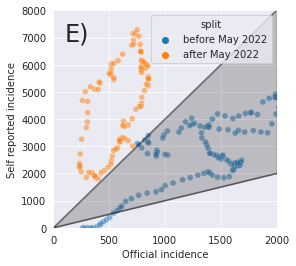

In [46]:
df = incidence_official.merge(incidence, on='date').sort_values(by="date").reset_index(drop=True).query('date>20220101').drop(columns=['PCR incidence', 'Antigen incidence'])
df['split'] = 'before May 2022'
df['split'][df['date'] > pd.to_datetime('20220501')] = 'after May 2022'

import seaborn as sns
# scatterplot of official vs self reported incidence with split by date
fig, ax = plt.subplots(figsize=(4, 4))
sns.scatterplot(x='official_incidence', y='all incidence', hue='split', data=df, ax=ax, alpha=0.5)

# plot line from (0, 0) to (5000, 5000)
factor = 4
length = 2000
ax.plot([0, length], [0, length * factor], color='black', alpha=0.5)
ax.plot([0, length], [0, length], color='black', alpha=0.5)
ax.fill_between([0, length], [0, length * factor], [0, length], color='black', alpha=0.2)
ax.set_xlim(0, length)
ax.set_ylim(0, length * factor)

ax.set_ylabel('Self reported incidence')
ax.set_xlabel('Official incidence')

# annotate with E in upper left corner
ax.text(0.05, 0.95, 'E)', transform=ax.transAxes, fontsize=24, verticalalignment='top')
fig.savefig('official_vs_self_reported_incidence_with_split.png')

/tmp/ipykernel_22615/1179108664.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['split'][df['date'] > split_date_1['date']] = f'after {split_date_1["name"]}'
/tmp/ipykernel_22615/1179108664.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['split'][df['date'] > split_date_2['date']] = f'after {split_date_2["name"]}'


all incidence


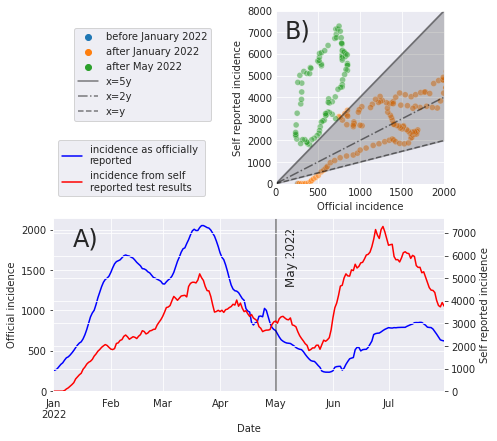

In [47]:
from typing import TypedDict
from datetime import timedelta

Date = TypedDict('Date', {'date': pd.Timestamp, 'name': str})

def plot_official_vs_self_reported_incidence(ax, legend_location, split_date: Date, df):
    axb = ax.twinx()

    df.plot(x="date", y="official_incidence", ax=ax, label="incidence as officially reported", color='blue', legend=False)

    colors = ['red']
    incidence_lines = []
    for column, color in zip(columns, colors):
        print(column)
        incidence_lines.append(Line2D([0], [0], color=color, label=column))
        df.plot(x="date", y=column, ax=axb, label="incidence from surveys", color=color, legend=False)

    # plot vertical line at split_date date and label with split date name
    ax.axvline(split_date['date'], color='black', alpha=0.5)
    ax.text(split_date['date'] + timedelta(days=5), ax.get_ylim()[1]*0.95 , split_date['name'], fontsize=12, verticalalignment='top', rotation=90)

    # create legend manually
    labels = ['incidence as officially \nreported', 'incidence from self \nreported test results']
    blue_line = Line2D([0], [0], color='blue', label='official incidence')
    ax.legend([blue_line, *incidence_lines], labels, bbox_to_anchor=legend_location)

    # label plot with A) in upper left corner
    axb.text(0.05, 0.95, 'A)', transform=ax.transAxes, fontsize=24, verticalalignment='top')

    # label axes
    ax.set_xlabel('Date')
    axb.set_ylabel('Self reported incidence')
    ax.set_ylabel('Official incidence')
    ax.set_ylim(0, ax.get_ylim()[1])
    axb.set_ylim(0, axb.get_ylim()[1])


def scatter_plot_with_split(ax, legend_location, split_date_1: Date, split_date_2: Date, df):

    df['split'] = f'before {split_date_1["name"]}'
    df['split'][df['date'] > split_date_1['date']] = f'after {split_date_1["name"]}'
    df['split'][df['date'] > split_date_2['date']] = f'after {split_date_2["name"]}'

    import seaborn as sns
    # scatterplot of official vs self reported incidence with split by date
    sns.scatterplot(x='official_incidence', y='all incidence', hue='split', data=df, ax=ax, alpha=0.5)

    # plot line from (0, 0) to (5000, 5000)
    factor = 4
    length = 2000

    ax.plot([0, length], [0, length * factor], label='x=5y', color='black', alpha=0.5)
    ax.plot([0, length], [0, length * 2], '-.', label='x=2y', color='black', alpha=0.5)
    ax.plot([0, length], [0, length], '--', label='x=y', color='black', alpha=0.5)

    ax.fill_between([0, length], [0, length * factor], [0, length], color='black', alpha=0.2)
    ax.set_xlim(0, length)
    ax.set_ylim(0, length * factor)

    # set legend position outside of plot on lower right
    ax.legend(loc='upper left', bbox_to_anchor=legend_location)

    # remove axis tics
    ax.tick_params(axis='both', which='both', length=0)
    # remove axis labels
    # ax.set_xticklabels([])
    # ax.set_yticklabels([])

    ax.set_ylabel('Self reported incidence')
    ax.set_xlabel('Official incidence')

    # label plot with B) in upper left corner
    ax.text(0.05, 0.95, 'B)', transform=ax.transAxes, fontsize=24, verticalalignment='top')

gridspecs = dict(width_ratios=[1, .9], height_ratios=[1, 1])
fig, axs = plt.subplot_mosaic([['upper left', 'upper right'],
                               ['lower', 'lower']], gridspec_kw=gridspecs, figsize=(7, 7))
# delete upper left subplot
axs['upper left'].remove()

df = incidence_official.merge(incidence, on='date').sort_values(by="date").reset_index(drop=True).query('date>20211115').drop(columns=['PCR incidence', 'Antigen incidence'])

scatter_plot_with_split(
    ax=axs['upper right'],
    legend_location=(-1.23, 0.93),
    split_date_1=dict(date=pd.to_datetime('20220101'), name='January 2022'),
    split_date_2=dict(date=pd.to_datetime('20220501'), name='May 2022'),
    df=df
)

plot_official_vs_self_reported_incidence(
    ax=axs['lower'],
    legend_location=(.4, 1.48),
    split_date=dict(date=pd.to_datetime('20220501'), name='May 2022'),
    df=df)
fig.savefig('official_vs_self_reported_incidence_with_scatter_subplot.png')

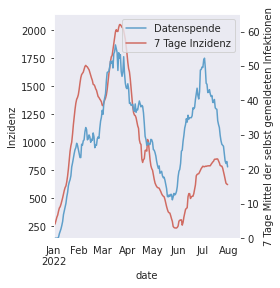

In [48]:
colors = ['#D06B62', '#5F9FCA']

df = daily_aggregate_test_data.rolling('7D').mean().merge(incidence_official, on='date')
df['date'] = df['date'].apply(pd.to_datetime)
df = df.set_index('date')[['all', 'official_incidence']]
df.columns = ['Datenspende Inziden', '7 Tage Inzidenz (RKI)']

fig, ax = plt.subplots(figsize=(4, 4))

axb = ax.twinx()

df[['Datenspende Inziden']].plot(ax=axb, color=colors[1], legend=False)
df[['7 Tage Inzidenz (RKI)']].plot(ax=ax, color=colors[0], legend=False)

ax.set_xlim(pd.to_datetime('20220101'), pd.to_datetime('20220815'))

labels = ['Datenspende', '7 Tage Inzidenz']
blue_line = Line2D([0], [0], color=colors[1], label='official incidence')
red_line = Line2D([0], [0], color=colors[0], label='self reported incidence')
ax.legend([blue_line, red_line], labels, loc='upper right')

ax.grid(False)
axb.grid(False)
axb.set_ylim(0, 65)

ax.set_ylabel('Inzidenz')
axb.set_ylabel('7 Tage Mittel der selbst gemeldeten Infektionen')

fig.tight_layout()
fig.savefig('Inzidenz.png', dpi=300, transparent=True)

In [49]:
colors = ['#D06B62', '#5F9FCA']

df = pd.read_csv('swabtestcount.csv')
df.columns = pd.Index(['DETECT Inzidenz', 'country', 'date', '7 Tage Inzidenz (RKI)'])
df['date'] = df['date'].apply(pd.to_datetime)
df = df.set_index('date')
df

,DETECT Inzidenz,country,7 Tage Inzidenz (RKI)
date,,,
2020-01-23,0.428571,United States,0
2020-01-24,0.428571,United States,1
2020-01-25,0.428571,United States,1
2020-01-26,0.428571,United States,1
2020-01-27,0.142857,United States,1
...,...,...,...
2022-07-28,7.142857,United States,126833
2022-07-29,7.142857,United States,124849
2022-07-30,8.428571,United States,122807


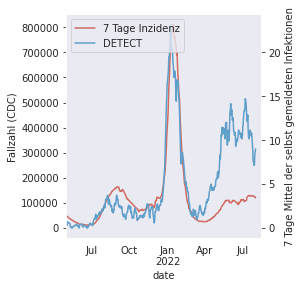

In [50]:
fig, ax = plt.subplots(figsize=(4.3, 4))

axb = ax.twinx()

df[['DETECT Inzidenz']].plot(ax=axb, color=colors[1], legend=False)
df[['7 Tage Inzidenz (RKI)']].plot(ax=ax, color=colors[0], legend=False)

ax.set_xlim(pd.to_datetime('20210501'), pd.to_datetime('20220815'))

labels = ['7 Tage Inzidenz', 'DETECT', ]
blue_line = Line2D([0], [0], color=colors[1], label='official incidence')
red_line = Line2D([0], [0], color=colors[0], label='self reported incidence')
axb.legend([red_line, blue_line, ], labels, loc='upper left')

ax.grid(False)
axb.grid(False)
# axb.set_ylim(0, 65)

ax.set_ylabel('Fallzahl (CDC)')
axb.set_ylabel('7 Tage Mittel der selbst gemeldeten Infektionen')

fig.tight_layout()
fig.savefig('Inzidenz_DETECT.png', dpi=300, transparent=True)

In [51]:
df = test_data.copy()
df['date'] = df['date'].apply(pd.to_datetime)
df = df[df['date']>pd.to_datetime('20220102')]
df['week'] = df['date'].dt.isocalendar().week
hist = df[['week', 'date']].groupby('week').agg({'date': ['count','first']})
hist.columns = ['#Answered surveys per week', 'date']
hist

,#Answered surveys per week,date
week,,
1,8271,2022-01-03
2,8861,2022-01-11
3,9332,2022-01-17
4,9434,2022-01-24
5,8676,2022-02-04
6,8632,2022-02-07
7,7165,2022-02-18
8,7733,2022-02-21
9,7942,2022-02-28


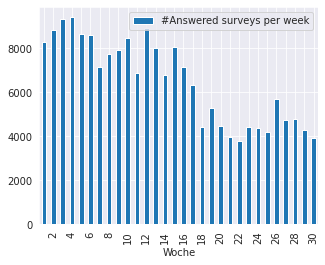

In [52]:
fig, ax = plt.subplots(figsize=(5, 4))
hist[['#Answered surveys per week']].plot(kind='bar', ax=ax)
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

ax.set_xlabel('Woche')
fig.savefig('Weekly_survey_respondents.png', dpi=300)

In [53]:
hist

,#Answered surveys per week,date
week,,
1,8271,2022-01-03
2,8861,2022-01-11
3,9332,2022-01-17
4,9434,2022-01-24
5,8676,2022-02-04
6,8632,2022-02-07
7,7165,2022-02-18
8,7733,2022-02-21
9,7942,2022-02-28
